#### **Introducción**: Se estima que los programas de gobiernmo de un país tienen alguna relación con los programas de gobierno de otros países que los antecedieron. Por ejemplo, Nueva Zelanda abordó el aspecto de 'Pueblos Originarios' con anterioridad a Chile de una manera considerada 'exitosa'. En Chile este aspecto ha permeado en los programas de Gobierno con fuerza desde 1989(*) en adelante; entonces es esperable que los programas de gobierno de Chile en lo relacionado con 'Pueblos Originarios' hayan sido incorporados en los programas de gobierno influidos por la experiencia de Nueva Zelanda.

* Utilizando el dataset de Manifesto Project buscaremos la existencia de correlaciones entre programas de gobierno, ya sea a nivel de todo el programa como también a nivel de ciertos aspectos específicos y dominios.
* Dominios:
*           * Relaciones internacionales
*           * Libertad y Democracia
*           * Sistema Político
*           * Economía
*           * Bienestar y Calidad de Vida
*           * Tejido Social
*           * Grupos Sociales

* Aspecto específicos:
       
*          * Inclusión y Minorías
*          * Orden y Corrupción
*          * Medio Ambiente y Sostenibilidad
*          * Pueblos Originarios
*          * Derechos Humanos
*          * Inmigración
*          * Moral Tradicional 


Pre proceso de la información:
* El dataset contiene información de 67 países entre 1920 y 2023.
* Los primeros 2 países fueron Estados Unidos y Canadá en 1920; luego se fueron incorporando el resto según se muestra en el siguiente cuadro:

<img src="../assets/Paises_por_año.png" alt="" width="550">

* **Consideraciones:**

*   * El país central en el análisis será Chile
*   * **En una primera aproximación se considerarán todas las variables disponibles para ver la existencia de relaciones entre programas de gobierno. Posteriormente se analizarán aspectos en particular.**
*   * Para homogeneizar el dataset, no introducir sesgo y dar cuenta de que no se dispone de información de todos los países todos los años, se agregó registros "cero" a cada país para los años previos a su incorporación al dataset.
*   * Dado que los países realizan sus elecciones en diferentes años, se realizará el análisis a nivel de períodos de 5 años (21 períodos de 5 años en total)
*   * Para cada país, para cada año de elección, se consolidará la información en base al promedio ponderado de las variables de interés, usando como peso para la ponderación el porcentaje de votos que obtuvo cada candidato o coalición. De esta manera tendremos un dataset 'ponderado'  en el cual cada país tiene un registro para cada año de elección. Este registro representa una aproximación 'al sentir nacional' reflejado en los programas de gobierno. 
*   * Se eliminó 107 registros de países con algún valor 'NaN' o 'Missing value'
* **Correlaciones**
*   * Se utilizó la correlación de Pearson
*   * Se consideró que un programa presidencial puede estar relacionado con los programas presidenciales que existián previos a él, y no los posteriores
*   * En primera instancia se correlacionaron todas los programas políticos del dataset ponderado, con los programas de Chile
*   * Se construye un heat map prelimimar
*
<img src="../assets/Heatmap_preliminar.png" alt="" width="750">
*

* **Red de Similaridad**
*   * Se construyó una red de similaridad donde los nodos son los programas de gobierno de cada países en cada período de 5 años, y donde los enlaces son la correlación entre un programa y los programas de Chile. Se utilizó la libraría NetworkX
*   * Los enlaces tienen un color más fuerte si es que la correlación es mayor
* **Clusters**
* * Se utilizó el algoritmo community_louvain para detectar clusters de países donde la correlación es más fuerte, según un umbral (threshold) determiando (85%)
*   * Se identifican 5 clusters preliminares:
*   * OBSERVACIÓN: Sólo se ve correlaciones con programas de gobierno del mismo período.
* 
<img src="../assets/Clusters_preliminar.png" alt="" width="550">




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

file_path = "data/MPDataset_MPDS2024a.csv"
df = pd.read_csv(file_path)

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5329/1447019918.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


#### Crear campo 'agno' para registrar el año del programa de gobierno

In [2]:
# Insert column 'agno' into the dataframe, of type int, to the right of column 'date'
df.insert(df.columns.get_loc('date') + 1, 'agno', df['edate'].str[-4:].astype(int))

# List unique values of new column 'agno'
unique_agno_values = df['agno'].unique()
print(unique_agno_values)

[1944 1948 1952 1956 1958 1960 1964 1968 1970 1973 1976 1979 1982 1985
 1988 1991 1994 1998 2002 2006 2010 2014 2018 2022 1945 1949 1953 1957
 1961 1965 1969 1977 1981 1989 1993 1997 2001 2005 2009 2013 2017 1947
 1950 1966 1971 1975 1984 1987 1990 2007 2011 2015 2019 1951 1954 1962
 1972 1983 1995 1999 2003 1946 1959 1963 1967 1974 1978 2016 2021 1986
 2012 2004 1992 1996 2008 2000 1980 1955 1921 1925 1929 1933 1938 2020
 1920 1924 1928 1932 1936 1940 2023]


In [3]:
df.head()

,country,countryname,oecdmember,eumember,edate,date,agno,party,partyname,partyabbrev,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,1944,11220,Communist Party of Sweden,SKP,...,NaN,NaN,NaN,9.60,1.9,1.900,0.0,1.900,2024a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,1944,11320,Social Democratic Labour Party,SAP,...,NaN,NaN,NaN,-37.80,3.3,2.200,33.4,5.600,2024a,CMR7F6
2,11,Sweden,0,0,17/09/1944,194409,1944,11420,People’s Party,FP,...,NaN,NaN,NaN,9.50,3.2,6.400,14.3,1.600,2024a,Z6OL6C
3,11,Sweden,0,0,17/09/1944,194409,1944,11620,Right Party,NaN,...,NaN,NaN,NaN,28.00,1.8,22.800,10.6,0.000,2024a,YMKVN2
4,11,Sweden,0,0,17/09/1944,194409,1944,11810,Agrarian Party,NaN,...,NaN,NaN,NaN,23.81,0.0,19.048,0.0,4.762,2024a,U4SCRD


In [4]:
unique_country_count = df['countryname'].nunique()
print(f"Number of unique countries: {unique_country_count}")

Number of unique countries: 67


#### Año de incorporación de los países al Manifesto Project

In [5]:
# Create a new dataframe 'df_in_mp' with columns 'agno_mp' and 'countryname'
df_in_mp = df.groupby('countryname')['date'].min().reset_index()

# Rename the 'date' column to 'agno_mp'
df_in_mp.rename(columns={'date': 'agno_mp'}, inplace=True)

df_in_mp_sorted = df_in_mp.sort_values(by='agno_mp', ascending=True)
# Add column 'agno_in' to 'df_in_mp_sorted' by taking the integer part of 'agno_mp' divided by 100
df_in_mp_sorted['agno_in'] = df_in_mp_sorted['agno_mp'] // 100


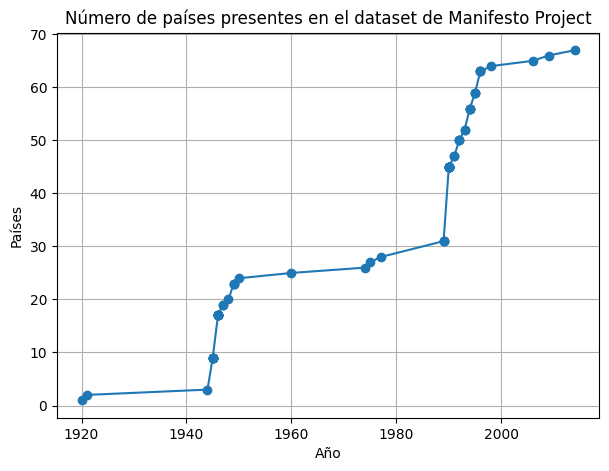

In [6]:
import matplotlib.pyplot as plt

# Create a new DataFrame to store the cumulative counts
cumulative_counts = df_in_mp_sorted.copy()

# Calculate the cumulative count of countries for each 'agno_in'
cumulative_counts['cumulative_count'] = cumulative_counts['agno_in'].rank(method='max').astype(int)

# Plot the cumulative counts
plt.figure(figsize=(7, 5))
plt.plot(cumulative_counts['agno_in'], cumulative_counts['cumulative_count'], marker='o')
plt.xlabel('Año')
plt.ylabel('Países')
plt.title('Número de países presentes en el dataset de Manifesto Project')
plt.grid(True)
plt.show()

In [7]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [8]:
# Identify all 'perxxxx' columns in df based on df_AD's 'Variable_per'
per_columns = df_AD['Variable_per'].tolist()

# Filter `perxxxx` columns that exist in `df`
valid_per_columns = [col for col in per_columns if col in df.columns]

# Ensure that `agno` column exists, or add a placeholder if not already in `df`
if 'agno' not in df.columns:
    df['agno'] = pd.to_datetime(df['edate'], errors='coerce').dt.year  # Create 'agno' from 'edate'

# Group by `countryname` and `agno` and sum the `perxxxx` columns
df_grouped = df.groupby(['countryname', 'agno'])[valid_per_columns].sum().reset_index()
df_grouped.head()


,countryname,agno,per101,per102,per103,per104,per105,per106,per107,per108,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,Albania,1991,6.282,0.0,2.655,9.957,1.421,5.668,23.541,15.549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Albania,1992,4.607,0.0,0.000,7.575,1.466,1.506,32.794,14.898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Albania,1996,15.248,0.0,0.917,4.513,0.552,2.175,8.259,4.941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Albania,1997,9.309,0.0,0.917,11.569,0.552,1.229,22.162,7.945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Albania,2001,5.310,0.0,0.000,4.604,0.552,0.403,11.280,3.659,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Agregamos la columna 'ventana_5' para agrupar las elecciones en períodos de 5 años entre 1920 y 2023
* Período 5 años : 1920, 1925, 1930, ... 2000, 2005, 2010, 2015, 2020, 2025

In [9]:
# cargar períodos
df_ventana_10 = pd.read_excel('data/Ventana_10.xlsx')
df_ventana_5 = pd.read_excel('data/Ventana_5.xlsx')

In [10]:
# en 'df' Insertamos columnas 'ventana_10' y 'ventana_5'
df = df.merge(df_ventana_10, on='agno', how='left').rename(columns={'ventana': 'ventana_10'})
df = df.merge(df_ventana_5, on='agno', how='left').rename(columns={'ventana': 'ventana_5'})

# Get the position of the 'agno' column
agno_index = df.columns.get_loc('agno')

# Move 'ventana_10' and 'ventana_5' to the right of 'agno'
columns = list(df.columns)
columns.insert(agno_index + 1, columns.pop(columns.index('ventana_10')))
columns.insert(agno_index + 2, columns.pop(columns.index('ventana_5')))
df = df[columns]

In [11]:
df

,country,countryname,oecdmember,eumember,edate,date,agno,ventana_10,ventana_5,party,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11220,...,NaN,NaN,NaN,9.600,1.900,1.900,0.000,1.900,2024a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11320,...,NaN,NaN,NaN,-37.800,3.300,2.200,33.400,5.600,2024a,CMR7F6
2,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11420,...,NaN,NaN,NaN,9.500,3.200,6.400,14.300,1.600,2024a,Z6OL6C
3,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11620,...,NaN,NaN,NaN,28.000,1.800,22.800,10.600,0.000,2024a,YMKVN2
4,11,Sweden,0,0,17/09/1944,194409,1944,140,5,11810,...,NaN,NaN,NaN,23.810,0.000,19.048,0.000,4.762,2024a,U4SCRD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5146,181,South Africa,0,0,08/05/2019,201905,2019,210,20,181510,...,0.0,5.000,0.0,12.500,0.833,7.500,14.167,0.000,2024a,HSQT6Y
5147,181,South Africa,0,0,08/05/2019,201905,2019,210,20,181520,...,0.0,1.042,0.0,-6.771,3.385,1.042,22.135,1.562,2024a,B6QCSE
5148,181,South Africa,0,0,08/05/2019,201905,2019,210,20,181710,...,0.0,3.497,0.0,19.580,0.699,10.664,11.364,0.000,2024a,OS725O
5149,181,South Africa,0,0,08/05/2019,201905,2019,210,20,181910,...,0.0,3.289,0.0,-6.579,0.658,0.658,28.947,0.000,2024a,XKM7J7


#### Hagamos la ponderación por año por país
#### debemos elegir entre 'pervote' o 'presvote' para ponderar. Si existe 'presvote' usamos ese si no, 'pervote'
#### Ponderemos

In [12]:
# Identificar las columnas que contienen los porcentajes
lista_columnas = [col for col in df.columns if col.startswith('per') and col[3:].isdigit()]

# Función para calcular el promedio ponderado con base en presvote o pervote
def calcular_promedio_ponderado(grupo):
    # Si presvote contiene solo ceros o valores nulos, se usará pervote
    if (grupo['presvote'].fillna(0) == 0).all():
        peso = grupo['pervote']
        tipovoto = 'pervote'
    else:
        peso = grupo['presvote']
        tipovoto = 'presvote'

    # Si ambas están en cero o vacías
    if peso.isna().all() or (peso == 0).all():
        tipovoto = 'no hay pervote ni presvote'
        peso = pd.Series(np.ones(len(grupo)))  # usar peso 1 para calcular el promedio simple

    # Calcular el promedio ponderado para cada columna de 'lista_columnas'
    ponderado = {}
    for col in lista_columnas:
        ponderado[col] = np.average(grupo[col], weights=peso)

    # Devolver un nuevo registro con los datos
    return pd.Series(
        [grupo['agno'].iloc[0], grupo['countryname'].iloc[0], grupo['ventana_10'].iloc[0], 
         grupo['ventana_5'].iloc[0], tipovoto] + list(ponderado.values()),
        index=['agno', 'countryname', 'ventana_10', 'ventana_5', 'tipovoto'] + lista_columnas
    )

# Agrupar por countryname y agno, y aplicar la función de promedio ponderado
df_ponderado = df.groupby(['countryname', 'agno']).apply(calcular_promedio_ponderado).reset_index(drop=True)

# Opcional: Mostrar el resultado
print(df_ponderado)


     agno    countryname  ventana_10  ventana_5  tipovoto    per101    per102  \
0    1991        Albania         190         15   pervote       NaN       NaN   
1    1992        Albania         190         15   pervote       NaN       NaN   
2    1996        Albania         190         16   pervote       NaN       NaN   
3    1997        Albania         190         16   pervote  1.770988  0.000000   
4    2001        Albania         200         17   pervote  2.392570  0.000000   
..    ...            ...         ...        ...       ...       ...       ...   
841  2008  United States         200         18   pervote  1.978711  0.088485   
842  2012  United States         210         19  presvote  0.505120  0.161887   
843  2016  United States         210         20  presvote  0.866280  0.111349   
844  2020  United States         220         21  presvote  1.190682  0.129249   
845  2014        Uruguay         210         19  presvote  0.058711  0.203054   

       per103    per104    

In [13]:
# Contar el número de filas que contienen valores 'NaN' en cualquier columna
num_filas_nan = df_ponderado.isna().any(axis=1).sum()
print(f"Número de filas en 'df_ponderado' que contienen valores 'NaN': {num_filas_nan}")
# Mostrar las filas que contienen valores 'NaN'
filas_con_nan = df_ponderado[df_ponderado.isna().any(axis=1)]
filas_con_nan


Número de filas en 'df_ponderado' que contienen valores 'NaN': 107


,agno,countryname,ventana_10,ventana_5,tipovoto,per101,per102,per103,per104,per105,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1991,Albania,190,15,pervote,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1992,Albania,190,15,pervote,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996,Albania,190,16,pervote,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2009,Argentina,200,18,pervote,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,2007,Belgium,200,18,pervote,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,1990,Slovenia,190,15,pervote,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
721,2016,Spain,210,20,pervote,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,2011,Switzerland,210,19,pervote,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772,2019,Switzerland,210,20,pervote,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Eliminemos las filas con 'NaN' o 'Missing values'. Obtenemos 'df_ponderado_sinnans'
df_ponderado_sinnans = df_ponderado.copy()

# Eliminar las filas que contienen valores 'NaN'
df_ponderado_sinnans = df_ponderado_sinnans.dropna()
display(df_ponderado_sinnans)


,agno,countryname,ventana_10,ventana_5,tipovoto,per101,per102,per103,per104,per105,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
3,1997,Albania,190,16,pervote,1.770988,0.000000,0.031388,3.046506,0.015910,...,2.021481,0.0,0.0,0.0,0.0,0.0,0.637892,0.363756,0.0,0.0
4,2001,Albania,200,17,pervote,2.392570,0.000000,0.000000,2.757403,0.026619,...,0.989546,0.0,0.0,0.0,0.0,0.0,0.897238,0.508457,0.0,0.0
5,1989,Argentina,180,14,presvote,0.000000,0.000000,4.619213,0.448618,0.828036,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
6,1995,Argentina,190,16,presvote,0.061642,0.020140,0.143247,0.882433,0.083005,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
7,1999,Argentina,190,16,presvote,0.192543,0.000000,0.582363,0.524400,0.017829,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,2008,United States,200,18,pervote,1.978711,0.088485,0.044020,5.839310,0.088485,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
842,2012,United States,210,19,presvote,0.505120,0.161887,0.189797,7.527242,1.491961,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
843,2016,United States,210,20,presvote,0.866280,0.111349,0.000000,5.807609,0.763045,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
844,2020,United States,220,21,presvote,1.190682,0.129249,0.161450,5.565559,1.951804,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [15]:
df_ponderado_sinnans.shape

(739, 115)

#### Ordenemos el dataset según períodos de 5 años. Para  cada país, se sumarán los valores de las variables de aquellos años dengtro del período


In [16]:
# Cambiemos el nombre a 'df_f
df_f = df_ponderado.copy()
# Eliminar las filas que contienen valores 'NaN'
df_f = df_f.dropna()
print(df_f.shape)
df_f.head()

(739, 115)


,agno,countryname,ventana_10,ventana_5,tipovoto,per101,per102,per103,per104,per105,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
3,1997,Albania,190,16,pervote,1.770988,0.00000,0.031388,3.046506,0.015910,...,2.021481,0.0,0.0,0.0,0.0,0.0,0.637892,0.363756,0.0,0.0
4,2001,Albania,200,17,pervote,2.392570,0.00000,0.000000,2.757403,0.026619,...,0.989546,0.0,0.0,0.0,0.0,0.0,0.897238,0.508457,0.0,0.0
5,1989,Argentina,180,14,presvote,0.000000,0.00000,4.619213,0.448618,0.828036,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
6,1995,Argentina,190,16,presvote,0.061642,0.02014,0.143247,0.882433,0.083005,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
7,1999,Argentina,190,16,presvote,0.192543,0.00000,0.582363,0.524400,0.017829,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


#### Consolidamos por país y por 'ventana_5'

In [17]:
# Crear el dataframe 'df_5' sumando los valores de las columnas que comienzan con 'per' agrupados por 'countryname' y 'ventana_5'

df_5 = df_f.groupby(['countryname', 'ventana_5'])[lista_columnas].sum().reset_index()

# Mostrar las primeras filas del nuevo dataframe 'df_5'
df_5


,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,Albania,16,1.770988,0.000000,0.031388,3.046506,0.015910,0.032313,3.406129,1.114989,...,2.021481,0.0,0.0,0.0,0.0,0.0,0.637892,0.363756,0.0,0.0
1,Albania,17,2.392570,0.000000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.989546,0.0,0.0,0.0,0.0,0.0,0.897238,0.508457,0.0,0.0
2,Argentina,14,0.000000,0.000000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,Argentina,16,0.254185,0.020140,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,Argentina,17,0.000000,0.000000,0.022605,0.113333,0.135937,0.233844,2.621821,1.451604,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,United States,18,1.978711,0.088485,0.044020,5.839310,0.088485,1.308294,8.863648,0.343947,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
546,United States,19,0.505120,0.161887,0.189797,7.527242,1.491961,0.658037,6.073936,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
547,United States,20,0.866280,0.111349,0.000000,5.807609,0.763045,0.635581,4.669601,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
548,United States,21,1.190682,0.129249,0.161450,5.565559,1.951804,0.480557,3.907785,0.020377,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [18]:
all_per_variables = [col for col in df_5.columns if col.startswith('per')]

#### Agreguemos registros cero para Chile para los períodos en que no hay información. Esto da consistencia en la comparación, se refleja que para ciertosmperíodos no hay datos lo que evita sesgo en la comparación, y mantiene la uniformidad en la red de similaridad

In [19]:
# Paso 1: Obtener la lista de todos los países en el dataframe
all_countries = df_5['countryname'].unique()

# Paso 2: Crear un DataFrame con todos los períodos posibles (1 al 21)
all_periods = pd.DataFrame({'ventana_5': list(range(1, 22))})

# Paso 3: Crear un DataFrame vacío para almacenar los registros faltantes
missing_periods_all = pd.DataFrame()

# Paso 4: Iterar sobre todos los países y generar registros con ceros para los períodos faltantes
for country in all_countries:
    # Filtrar los períodos existentes del país en df_5
    existing_periods = df_5[df_5['countryname'] == country]['ventana_5'].unique()
    
    # Determinar los períodos faltantes para el país
    missing_periods = all_periods[~all_periods['ventana_5'].isin(existing_periods)]
    
    # Crear registros con valores cero para los períodos faltantes
    missing_data = pd.DataFrame({
        'countryname': [country] * len(missing_periods),
        'ventana_5': missing_periods['ventana_5']
    })
    
    # Asignar valores cero a todas las variables 'per'
    for col in all_per_variables:
        missing_data[col] = 0.0
    
    # Agregar los registros faltantes al DataFrame total
    missing_periods_all = pd.concat([missing_periods_all, missing_data], ignore_index=True)

# Paso 5: Combinar los registros faltantes con el DataFrame original
df_5_extended = pd.concat([df_5, missing_periods_all], ignore_index=True)

# Paso 6: Verificar que ahora todos los países tengan datos para todos los períodos
df_5_extended.groupby('countryname')['ventana_5'].nunique()


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5329/2392521840.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  missing_data[col] = 0.0
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5329/2392521840.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  missing_data[col] = 0.0
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5329/2392521840.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

countryname
Albania           21
Argentina         21
Armenia           21
Australia         21
Austria           21
                  ..
Turkey            21
Ukraine           21
United Kingdom    21
United States     21
Uruguay           21
Name: ventana_5, Length: 66, dtype: int64

In [20]:
df_5_extended.head()

,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,Albania,16,1.770988,0.00000,0.031388,3.046506,0.015910,0.032313,3.406129,1.114989,...,2.021481,0.0,0.0,0.0,0.0,0.0,0.637892,0.363756,0.0,0.0
1,Albania,17,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.989546,0.0,0.0,0.0,0.0,0.0,0.897238,0.508457,0.0,0.0
2,Argentina,14,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,Argentina,16,0.254185,0.02014,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,Argentina,17,0.000000,0.00000,0.022605,0.113333,0.135937,0.233844,2.621821,1.451604,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


#### Correlación y Threshold

In [29]:
threshold = 0.85

In [21]:
# Paso 1: Filtrar todas las columnas que comienzan con 'per'
all_per_variables = [col for col in df_5_extended.columns if col.startswith('per')]

# Paso 2: Filtrar los datos de Chile para obtener los períodos correspondientes
df_chile = df_5_extended[df_5_extended['countryname'] == 'Chile'].copy()

# Paso 3: Crear un diccionario para almacenar las correlaciones de todos los países con Chile por período
correlation_results = {}

# Paso 4: Iterar por cada período en 'ventana_5' para hacer las correlaciones por período
for period in df_chile['ventana_5'].unique():
    # Extraer los datos de Chile para el período específico (todas las variables 'per')
    chile_data = df_chile[df_chile['ventana_5'] == period][all_per_variables].iloc[0].dropna()

    # Asegurar que los datos sean numéricos
    chile_data = pd.to_numeric(chile_data, errors='coerce')

    # Filtrar los datos de los demás países en el mismo período o en períodos anteriores
    df_other_countries = df_5_extended[(df_5_extended['ventana_5'] <= period) & (df_5_extended['countryname'] != 'Chile')]

    # Iterar por cada país y calcular la correlación con Chile en ese mismo período o en períodos anteriores
    for index, row in df_other_countries.iterrows():
        country_period = row['countryname'] + '_' + str(row['ventana_5'])  # Crear 'countryname + ventana_5'
        country_data = row[all_per_variables].dropna()

        # Asegurar que los datos sean numéricos
        country_data = pd.to_numeric(country_data, errors='coerce')

        # Calcular la correlación de Pearson entre Chile y el otro país en ese mismo período o en períodos anteriores
        correlation = chile_data.corr(country_data)

        # Guardar la correlación en el diccionario si no es NaN
        if pd.notna(correlation):
            correlation_results[country_period] = correlation

# Paso 5: Convertir los resultados a un DataFrame para visualización
df_correlations = pd.DataFrame(list(correlation_results.items()), columns=['Country_Period', 'Correlation_with_Chile'])
df_correlations.head()


,Country_Period,Correlation_with_Chile
0,Argentina_14,0.532907
1,Australia_6,0.343533
2,Australia_7,0.280467
3,Australia_8,0.342136
4,Australia_9,0.305716


#### Heat Map y Red de Similitud

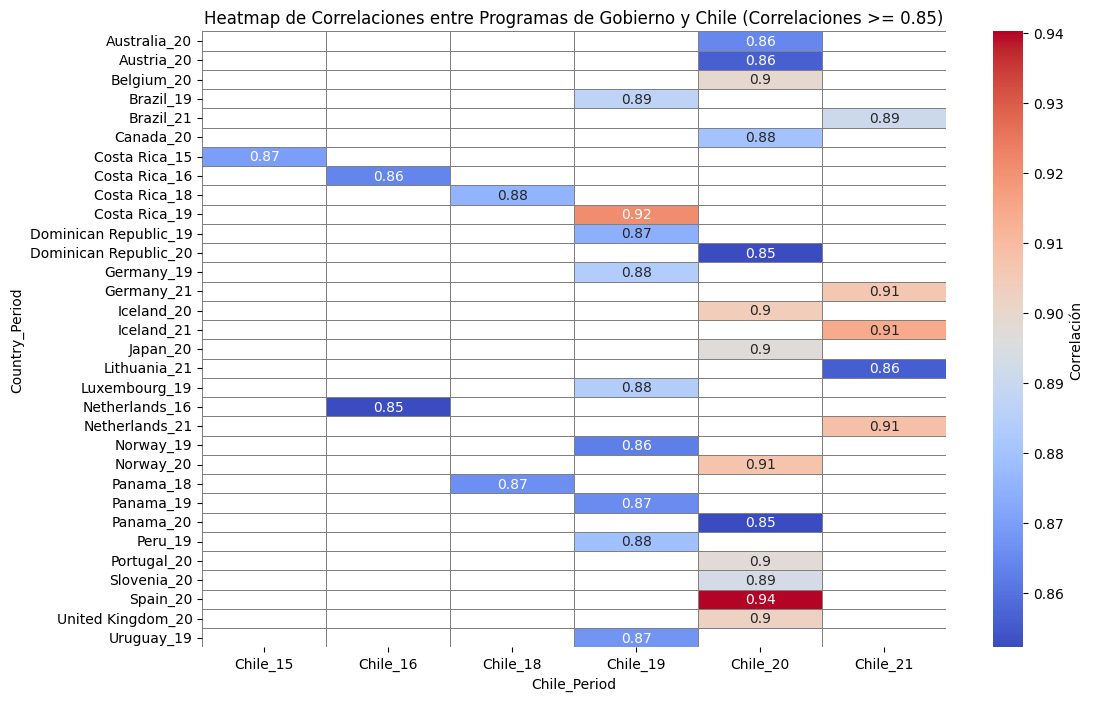

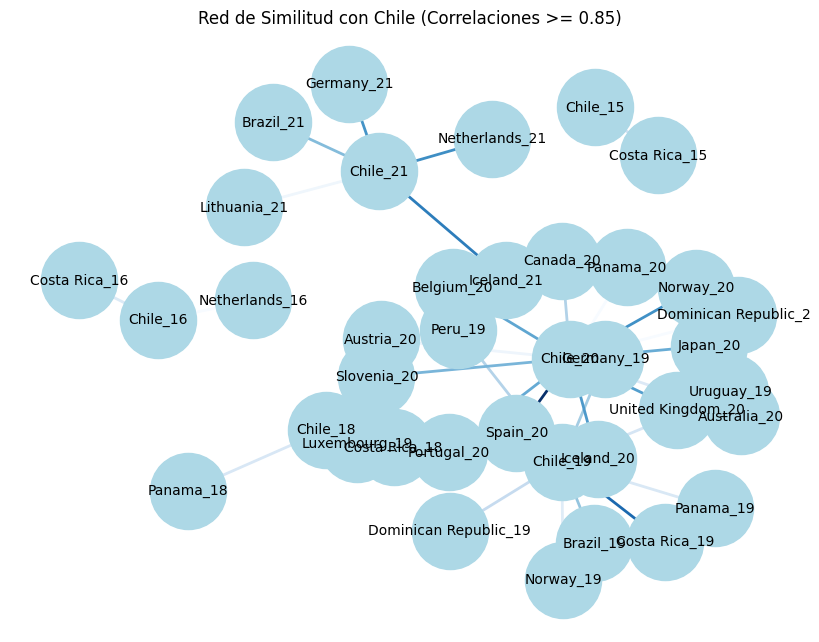

In [34]:
# Paso 6: Filtrar las correlaciones según un umbral
df_filtered_correlations = df_correlations[df_correlations['Correlation_with_Chile'] >= threshold]

# Heat map
# Crear una copia de df_filtered_correlations para no modificar el original
df_heatmap_correlations = df_filtered_correlations.copy()

# Paso 1: Crear una columna separada para el período de Chile en la copia
df_heatmap_correlations['Chile_Period'] = df_heatmap_correlations['Country_Period'].apply(lambda x: 'Chile_' + x.split('_')[1])

# Paso 2: Crear una matriz de correlaciones: filas son Country_Period y columnas son Chile_Period
heatmap_data = df_heatmap_correlations.pivot(index='Country_Period', columns='Chile_Period', values='Correlation_with_Chile')

# Paso 3: Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Correlación'})

# Agregar título y etiquetas
plt.title(f'Heatmap de Correlaciones entre Programas de Gobierno y Chile (Correlaciones >= {threshold})')
plt.ylabel('Country_Period')
plt.xlabel('Chile_Period')

# Mostrar el gráfico
plt.show()

# Paso 7: Crear la red de similitud basada en correlaciones con Chile
G = nx.Graph()

# Añadir los nodos y enlaces con pesos (correlaciones) al grafo
for i, row in df_filtered_correlations.iterrows():
    # Crear el enlace entre 'Chile' y el país-período
    G.add_edge('Chile_' + str(row['Country_Period'].split('_')[1]), row['Country_Period'], weight=row['Correlation_with_Chile'])

# Paso 8: Dibujar el grafo
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, k=0.5, seed=42)  # Posicionamiento de los nodos
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]  # Extraer los pesos (correlaciones) para las aristas

# Dibujar el grafo con pesos en las aristas
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', 
        font_size=10, edge_color=weights, width=2, edge_cmap=plt.cm.Blues)
plt.title(f'Red de Similitud con Chile (Correlaciones >= {threshold})')
plt.show()

### Comentario: Sólo se observan correlaciones entre programas de gobierno del mismo período.
### REVISAR

#### Veamos que programas hay en el grafo y las correlaciones para el threshold dado

In [35]:
# Crear el DataFrame filtrado con correlaciones >= threshold
df_filtered_correlations = df_correlations[df_correlations['Correlation_with_Chile'] >= threshold].copy()

# Extraer el período de Chile para cada correlación
df_filtered_correlations['Chile_Period'] = df_filtered_correlations['Country_Period'].apply(lambda x: 'Chile_' + x.split('_')[1])

# Guardar el dataframe filtrado en un archivo CSV para que puedas revisarlo si es necesario
df_filtered_correlations.to_csv('correlaciones_filtradas_con_chile.csv', index=False)

# Mostrar las primeras filas
df_filtered_correlations.head()



,Country_Period,Correlation_with_Chile,Chile_Period
243,Costa Rica_15,0.870053,Chile_15
291,Costa Rica_16,0.864112,Chile_16
310,Netherlands_16,0.852378,Chile_16
352,Costa Rica_18,0.875413,Chile_18
398,Panama_18,0.866080,Chile_18


In [36]:
df_filtered_correlations.shape

(32, 3)

#### Veamos clusters

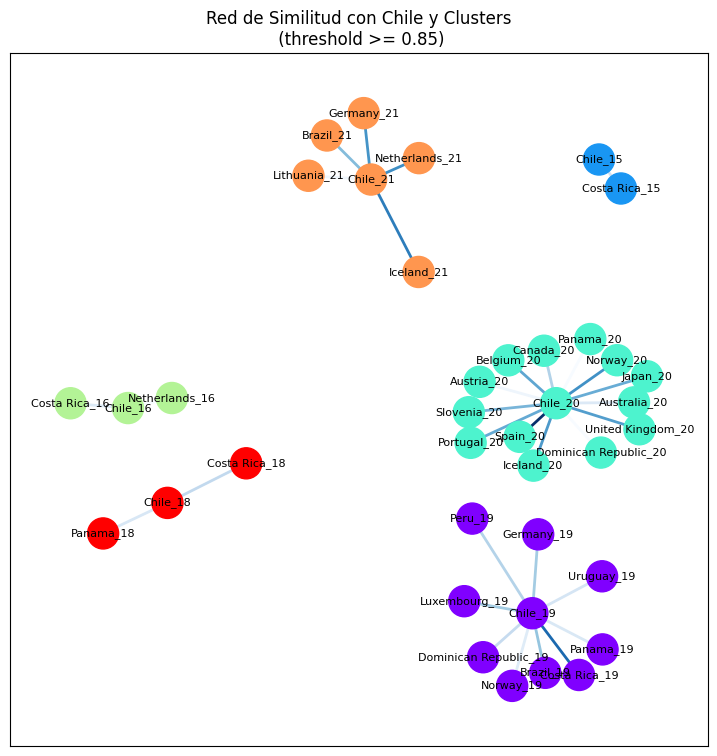

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

# Crear el grafo de similitud con el dataframe filtrado por correlaciones >= threshold
df_filtered_correlations = df_correlations[df_correlations['Correlation_with_Chile'] >= threshold]

# Crear la red (grafo) con NetworkX
G = nx.Graph()

# Añadir nodos y enlaces con pesos (correlaciones) al grafo
for i, row in df_filtered_correlations.iterrows():
    G.add_edge('Chile_' + str(row['Country_Period'].split('_')[1]), row['Country_Period'], weight=row['Correlation_with_Chile'])

# Identificar los clústeres en la red usando Louvain (o Girvan-Newman)
import community as community_louvain
louvain_partition = community_louvain.best_partition(G)

# Convertir comunidades en un formato más fácil de leer
community_dict = louvain_partition

# Posicionamiento del grafo con layout "spring" ajustado
pos = nx.spring_layout(G, k=0.3, seed=42)
# Usar el layout Fruchterman-Reingold
# pos = nx.fruchterman_reingold_layout(G)


# **Amplitud del Grafo**: Aumentar el tamaño de la figura
plt.figure(figsize=(9, 9))  # Aumenta el tamaño de la figura. Prueba con valores mayores si lo necesitas.

# Dibujar nodos y asignar colores basados en los clústeres
node_colors = [community_dict[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=500)

# Dibujar aristas (enlaces) ponderados por correlación
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, edge_color=weights, edge_cmap=plt.cm.Blues, width=2)

# **Ajustar el Tamaño de la Fuente** de las etiquetas
nx.draw_networkx_labels(G, pos, font_size=8)  # Cambia 'font_size' a un valor menor (por ejemplo, 8 o 10)

# Agregar título y mostrar el grafo
plt.title(f'Red de Similitud con Chile y Clusters\n (threshold >= {threshold})')
plt.show()


#### Veamos qué programas de gobierno hay en cada cluster y la correlación

In [38]:
# Crear el grafo de similitud con el dataframe filtrado por correlaciones >= threshold
df_filtered_correlations = df_correlations[df_correlations['Correlation_with_Chile'] >= threshold].copy()

# Crear la red (grafo) con NetworkX
G = nx.Graph()

# Añadir nodos y enlaces con pesos (correlaciones) al grafo
for i, row in df_filtered_correlations.iterrows():
    G.add_edge('Chile_' + str(row['Country_Period'].split('_')[1]), row['Country_Period'], weight=row['Correlation_with_Chile'])

# Paso 1: Identificar los clústeres en la red (usando Girvan-Newman para este ejemplo)
communities = community.girvan_newman(G)
top_level_communities = next(communities)

# Convertir comunidades en un formato legible, asignando un número de clúster a cada nodo
community_dict = {node: i for i, community in enumerate(top_level_communities) for node in community}

# Paso 2: Crear un dataframe con los programas de gobierno y su clúster
df_filtered_correlations['Cluster'] = df_filtered_correlations['Country_Period'].apply(lambda x: community_dict.get(x))

# Paso 3: Añadir la correlación con Chile
df_filtered_correlations['Chile_Period'] = df_filtered_correlations['Country_Period'].apply(lambda x: 'Chile_' + x.split('_')[1])

# Paso 4: Reorganizar las columnas para mayor claridad
df_clusters = df_filtered_correlations[['Cluster', 'Country_Period', 'Chile_Period', 'Correlation_with_Chile']].copy()

# Guardar el dataframe en un archivo CSV para revisarlo más tarde
df_clusters.to_csv('programas_y_clusters.csv', index=False)
df_clusters.head()

,Cluster,Country_Period,Chile_Period,Correlation_with_Chile
243,0,Costa Rica_15,Chile_15,0.870053
291,1,Costa Rica_16,Chile_16,0.864112
310,1,Netherlands_16,Chile_16,0.852378
352,2,Costa Rica_18,Chile_18,0.875413
398,2,Panama_18,Chile_18,0.866080
